In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#Inspired by https://www.kaggle.com/code/mahmoudlimam/resampling-tutorial
# Importance measurement - f1 score (recall & precision)

y_col = "HeartDiseaseOrAttack"
colsToDrop = ["State"]

In [99]:
df = pd.read_csv('../data/heart_disease_health_indicators_BRFSS2021.csv')

for col in colsToDrop:
    df = df.drop(col, axis=1)

<AxesSubplot: xlabel='HeartDiseaseOrAttack', ylabel='count'>

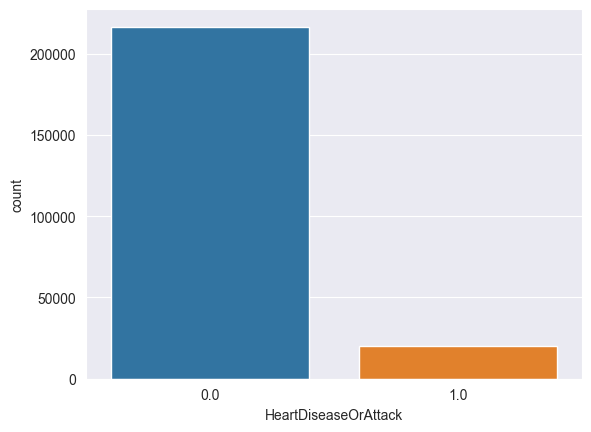

In [100]:
sns.countplot(data=df, x=y_col)

In [101]:
X = df.drop(y_col, axis=1)
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [57]:
def train_evaluate(X_train, X_test, y_train, y_test, sampler=None, model=None, depth=12):

    if model is None:
        model = RandomForestClassifier(n_jobs=-1, max_depth=depth, class_weight="balanced_subsample", verbose=1, random_state=9)
        #model = RandomForestClassifier(n_jobs=-1, max_depth=6, verbose=1, random_state=7)

    Xs_train, ys_train = X_train, y_train

    if sampler is not None:
        Xs_train, ys_train = sampler.fit_resample(X_train, y_train)

    model.fit(Xs_train, ys_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Training Results:\n")
    print(classification_report(y_train, y_pred_train))
    print("\n\nTesting Results:\n")
    print(classification_report(y_test, y_pred_test))

In [58]:
# Without re-sampling
train_evaluate(X_train, X_test, y_train, y_test, depth=6)

# With no re-sampling we get for test (max depth 6, default):
# Recall for 1.0: 0.01 --> 0.83
# Macro-Average F1: 0.48 --> 0.59


# 1 = 0.75, 0.58
# 2 = 0.78, 0.59
# 3 = 0.74, 0.59
# 6 = 0.83, 0.59 # High recall, low precision
# 10 = 0.8, 0.61
# 15 = 0.58, 0.65
# 20 = 0.31, 0.63
# 25 = 0.14, 0.58
# 50 = 0.06, 0.53

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83    173132
         1.0       0.22      0.83      0.35     16314

    accuracy                           0.73    189446
   macro avg       0.60      0.78      0.59    189446
weighted avg       0.91      0.73      0.79    189446



Testing Results:

              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     43425
         1.0       0.21      0.83      0.34      3937

    accuracy                           0.73     47362
   macro avg       0.60      0.78      0.59     47362
weighted avg       0.92      0.73      0.79     47362



In [59]:
## -- Undersampling --

#Random Undersampling
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(random_state=11)

train_evaluate(X_train, X_test, y_train, y_test, sampler)

# Test Results:
# Recall for 1.0: 0.01 -> 0.83 --> 0.83
# Macro-Average F1: 0.48 -> 0.58 --> 0.59

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.84    173132
         1.0       0.24      0.90      0.38     16314

    accuracy                           0.75    189446
   macro avg       0.61      0.82      0.61    189446
weighted avg       0.92      0.75      0.80    189446



Testing Results:

              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84     43425
         1.0       0.22      0.83      0.34      3937

    accuracy                           0.74     47362
   macro avg       0.60      0.78      0.59     47362
weighted avg       0.92      0.74      0.79     47362



In [60]:
import faiss

#https://towardsdatascience.com/k-means-8x-faster-27x-lower-error-than-scikit-learns-in-25-lines-eaedc7a3a0c8
# class FaissKMeans:
#     def __init__(self, n_clusters=8, n_init=10, max_iter=300):
#         self.n_clusters = n_clusters
#         self.n_init = n_init
#         self.max_iter = max_iter
#         self.kmeans = None
#         self.cluster_centers_ = None
#         self.inertia_ = None
#
#     def fit(self, X, y=None):
#         self.kmeans = faiss.Kmeans(d=X.shape[1],
#                                    k=self.n_clusters,
#                                    niter=self.max_iter,
#                                    nredo=self.n_init)
#         self.kmeans.train(X.astype(np.float32))
#         self.cluster_centers_ = self.kmeans.centroids
#         self.inertia_ = self.kmeans.obj[-1]
#
#     def predict(self, X):
#         return self.kmeans.index.search(X.astype(np.float32), 1)[1]
#
#     def get_params(self, deep=True):
#         out = dict()
#         out["n_clusters"] = self.n_clusters
#         out["n_init"] = self.n_init
#         out["max_iter"] = self.max_iter
#         return out
#
#     def set_params(self, **params):
#         for key, value in params.items():
#             setattr(self, key, value)
#         return self

In [61]:
# Cluster Centroid Undersampling
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(verbose=1, batch_size=4096)
sampler = ClusterCentroids(estimator=kmeans)

# Time consuming
# train_evaluate(X_train, X_test, y_train, y_test, sampler)

# Test Results:
# Recall for 1.0: 0.01 -> 0.98
# Macro-Average F1: 0.48 -> 0.33

In [62]:
## Oversampling

# Random Oversampling
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(random_state=11)

train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.83 -> 0.70
# Macro-Average F1: 0.48 -> 0.59 -> 0.63

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88    173132
         1.0       0.29      0.88      0.43     16314

    accuracy                           0.80    189446
   macro avg       0.64      0.84      0.66    189446
weighted avg       0.93      0.80      0.84    189446



Testing Results:

              precision    recall  f1-score   support

         0.0       0.97      0.78      0.87     43425
         1.0       0.24      0.77      0.37      3937

    accuracy                           0.78     47362
   macro avg       0.61      0.77      0.62     47362
weighted avg       0.91      0.78      0.83     47362



In [63]:
#SMOTE Oversampling
from imblearn.over_sampling import SMOTE

sampler = SMOTE(k_neighbors=5, random_state=11)
train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.61 - 0.35
# Macro-Average F1: 0.48 -> 0.64 -> 0.65

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    173132
         1.0       0.39      0.45      0.41     16314

    accuracy                           0.89    189446
   macro avg       0.67      0.69      0.68    189446
weighted avg       0.90      0.89      0.90    189446



Testing Results:

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94     43425
         1.0       0.35      0.40      0.37      3937

    accuracy                           0.89     47362
   macro avg       0.65      0.67      0.66     47362
weighted avg       0.90      0.89      0.89     47362



In [64]:
# Borderline SMOTE
from imblearn.over_sampling import BorderlineSMOTE
sampler = BorderlineSMOTE(k_neighbors=5, random_state=11)

train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.59
# Macro-Average F1: 0.48 -> 0.64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    173132
         1.0       0.38      0.47      0.42     16314

    accuracy                           0.89    189446
   macro avg       0.67      0.70      0.68    189446
weighted avg       0.90      0.89      0.89    189446



Testing Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     43425
         1.0       0.35      0.42      0.38      3937

    accuracy                           0.89     47362
   macro avg       0.65      0.67      0.66     47362
weighted avg       0.90      0.89      0.89     47362



In [65]:
from smote_variants import DBSMOTE
oversampler = DBSMOTE(min_samples=10)

train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.6
# Macro-Average F1: 0.48 -> 0.64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    173132
         1.0       0.38      0.47      0.42     16314

    accuracy                           0.89    189446
   macro avg       0.67      0.70      0.68    189446
weighted avg       0.90      0.89      0.89    189446



Testing Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     43425
         1.0       0.35      0.42      0.38      3937

    accuracy                           0.89     47362
   macro avg       0.65      0.67      0.66     47362
weighted avg       0.90      0.89      0.89     47362



In [66]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

#df_scaled = scaler.fit_transform(df.to_numpy())
#df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

#X_scal = df.drop(y_col, axis=1)
#y_scal = df[y_col]

#X_scal_train, X_scal_test, y_scal_train, y_scal_test = train_test_split(X_scal, y_scal, test_size=0.1, random_state=45)

In [67]:
from sklearn.ensemble import HistGradientBoostingClassifier
model2 = HistGradientBoostingClassifier(class_weight='balanced')

train_evaluate(X_train_scal, X_test_scal, y_train, y_test, model=model2)
# With Scaling
# 0.83, 0.60

Training Results:

              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85    173132
         1.0       0.24      0.84      0.37     16314

    accuracy                           0.75    189446
   macro avg       0.61      0.79      0.61    189446
weighted avg       0.92      0.75      0.81    189446



Testing Results:

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85     43425
         1.0       0.23      0.82      0.35      3937

    accuracy                           0.75     47362
   macro avg       0.60      0.78      0.60     47362
weighted avg       0.92      0.75      0.80     47362



In [120]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

X_clean = X.drop("DiabetesAge", axis=1)

toDrop = ["DiabetesAge"]

X_cat = X.drop(toDrop, axis=1)
X_cat["BMI"] =  pd.cut(X_cat["BMI"], [0,20,40,60,80,100], labels=[0, 1, 2, 3, 4] ,include_lowest=True)
X_cat["FruitsPerDay"] = pd.cut(X_cat["FruitsPerDay"], [0,0.5,1,2,4,8], labels=[0, 1, 2, 3, 4] ,include_lowest=True)
X_cat["DarkGreensPerDay"] = pd.cut(X_cat["DarkGreensPerDay"], [0,0.5,1,2,4, 8], labels=[0, 1, 2, 3, 4] ,include_lowest=True)
X_cat["PotatoesPerDay"] = pd.cut(X_cat["PotatoesPerDay"], [0, 0.25, 0.5,1,2,4, 8], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)
X_cat["OtherVegPerDay"] = pd.cut(X_cat["OtherVegPerDay"], [0, 0.25, 0.5,1,2,4, 8], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)
X_cat["BadMentalHealthLast30Days"] = pd.cut(X_cat["BadMentalHealthLast30Days"], [0, 5, 10, 15, 20, 25, 30], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)
X_cat["BadPhysicalHealthLast30Days"] = pd.cut(X_cat["BadPhysicalHealthLast30Days"], [0, 5, 10, 15, 20, 25, 30], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)

In [121]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, random_state=109)

In [122]:
np.any(np.isnan(y_test_cat.values))

False

In [142]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn import metrics

def evalBayes(model, sampler=None):

    new_X_train_cat, new_X_test_cat, new_y_train_cat, new_y_test_cat = train_test_split(X_cat, y, test_size=0.2, random_state=109)

    X_train_toUse = new_X_train_cat
    y_train_toUse = new_y_train_cat

    if(sampler is not None):
        X_train_toUse, y_train_toUse = sampler.fit_resample(new_X_train_cat, new_y_train_cat)

    model.fit(X_train_toUse, y_train_toUse)

    new_y_pred_cat = model.predict(new_X_test_cat)

    print("Accuracy: ", metrics.accuracy_score(new_y_test_cat, new_y_pred_cat))

    print(classification_report(new_y_test_cat, new_y_pred_cat))

    return model, new_y_test_cat, new_y_pred_cat

In [72]:
gnb = GaussianNB()

evalBayes(gnb)

Accuracy:  0.8091296820235632
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89     65137
         1.0       0.25      0.62      0.35      5906

    accuracy                           0.81     71043
   macro avg       0.60      0.72      0.62     71043
weighted avg       0.90      0.81      0.84     71043



(GaussianNB(),
 101637   0.000
 118159   1.000
 111167   0.000
 164341   0.000
 169897   0.000
           ... 
 140673   0.000
 200787   0.000
 79426    0.000
 232733   0.000
 29106    0.000
 Name: HeartDiseaseOrAttack, Length: 71043, dtype: float64,
 array([0., 0., 0., ..., 0., 0., 0.]))

In [73]:
evalBayes(MultinomialNB())

Accuracy:  0.8578466562504399
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     65137
         1.0       0.26      0.40      0.32      5906

    accuracy                           0.86     71043
   macro avg       0.60      0.65      0.62     71043
weighted avg       0.89      0.86      0.87     71043



(MultinomialNB(),
 101637   0.000
 118159   1.000
 111167   0.000
 164341   0.000
 169897   0.000
           ... 
 140673   0.000
 200787   0.000
 79426    0.000
 232733   0.000
 29106    0.000
 Name: HeartDiseaseOrAttack, Length: 71043, dtype: float64,
 array([0., 0., 0., ..., 0., 0., 0.]))

In [74]:
evalBayes(MultinomialNB())

Accuracy:  0.8578466562504399
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     65137
         1.0       0.26      0.40      0.32      5906

    accuracy                           0.86     71043
   macro avg       0.60      0.65      0.62     71043
weighted avg       0.89      0.86      0.87     71043



(MultinomialNB(),
 101637   0.000
 118159   1.000
 111167   0.000
 164341   0.000
 169897   0.000
           ... 
 140673   0.000
 200787   0.000
 79426    0.000
 232733   0.000
 29106    0.000
 Name: HeartDiseaseOrAttack, Length: 71043, dtype: float64,
 array([0., 0., 0., ..., 0., 0., 0.]))

In [75]:
evalBayes(ComplementNB())

Accuracy:  0.7499542530580071
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.85     65137
         1.0       0.21      0.70      0.32      5906

    accuracy                           0.75     71043
   macro avg       0.59      0.73      0.58     71043
weighted avg       0.90      0.75      0.80     71043



(ComplementNB(),
 101637   0.000
 118159   1.000
 111167   0.000
 164341   0.000
 169897   0.000
           ... 
 140673   0.000
 200787   0.000
 79426    0.000
 232733   0.000
 29106    0.000
 Name: HeartDiseaseOrAttack, Length: 71043, dtype: float64,
 array([0., 0., 1., ..., 0., 0., 0.]))

In [76]:
evalBayes(BernoulliNB())

Accuracy:  0.851076108835494
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92     65137
         1.0       0.28      0.49      0.36      5906

    accuracy                           0.85     71043
   macro avg       0.61      0.69      0.64     71043
weighted avg       0.89      0.85      0.87     71043



(BernoulliNB(),
 101637   0.000
 118159   1.000
 111167   0.000
 164341   0.000
 169897   0.000
           ... 
 140673   0.000
 200787   0.000
 79426    0.000
 232733   0.000
 29106    0.000
 Name: HeartDiseaseOrAttack, Length: 71043, dtype: float64,
 array([0., 0., 0., ..., 0., 0., 0.]))

In [77]:
evalBayes(CategoricalNB())

Accuracy:  0.8387314724884929
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     65137
         1.0       0.28      0.58      0.37      5906

    accuracy                           0.84     71043
   macro avg       0.62      0.72      0.64     71043
weighted avg       0.90      0.84      0.86     71043



(CategoricalNB(),
 101637   0.000
 118159   1.000
 111167   0.000
 164341   0.000
 169897   0.000
           ... 
 140673   0.000
 200787   0.000
 79426    0.000
 232733   0.000
 29106    0.000
 Name: HeartDiseaseOrAttack, Length: 71043, dtype: float64,
 array([0., 0., 0., ..., 0., 0., 0.]))

In [78]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sampler = BorderlineSMOTE(random_state=11)

hgbc = HistGradientBoostingClassifier()

m, test, pred = evalBayes(hgbc, sampler)

Accuracy:  0.9173036048590291
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     65137
         1.0       0.51      0.13      0.21      5906

    accuracy                           0.92     71043
   macro avg       0.72      0.56      0.58     71043
weighted avg       0.89      0.92      0.89     71043



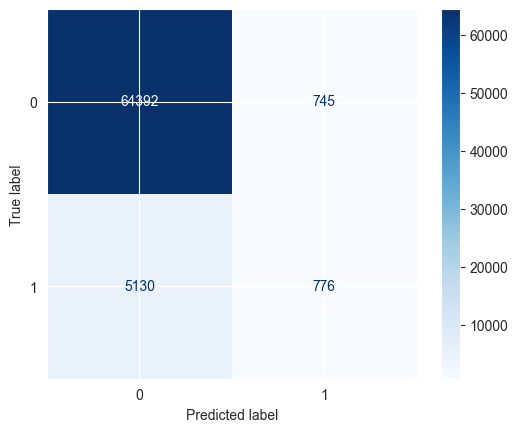

In [79]:
cm = confusion_matrix(test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [144]:
rfc = RandomForestClassifier(n_jobs=-1)

evalBayes(rfc)

Accuracy:  0.912862632490182
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     43343
         1.0       0.44      0.11      0.17      4019

    accuracy                           0.91     47362
   macro avg       0.68      0.55      0.56     47362
weighted avg       0.88      0.91      0.89     47362



(RandomForestClassifier(n_jobs=-1),
 101637   0.000
 118159   1.000
 111167   0.000
 164341   0.000
 169897   0.000
           ... 
 90860    0.000
 63804    0.000
 150785   0.000
 200909   0.000
 121130   0.000
 Name: HeartDiseaseOrAttack, Length: 47362, dtype: float64,
 array([0., 1., 0., ..., 0., 0., 0.]))

HighBP = 0.016100884716838165
HighChol = 0.023472227026804026
CholCheckLast5Years = 0.003179718195783851
BMI = 0.02053919883055021
Smoker = 0.024562360444767894
Stroke = 0.019880513144669647
Diabetes = 0.03225629284556692
PhysActivityLast30Days = 0.029307661416135996
FruitsPerDay = 0.07299821787449765
DarkGreensPerDay = 0.044685392293443885
PotatoesPerDay = 0.05258014394704835
OtherVegPerDay = 0.07336450390611034
HeavyDrinker = 0.010448734421187857
AnyHealthcare = 0.004684882420895623
CantAffordHealthcare = 0.011234281837160971
GeneralHealth = 0.06496978306012355
BadMentalHealthLast30Days = 0.03595454380203185
BadPhysicalHealthLast30Days = 0.03895933382645157
DiffWalking = 0.023392586096220958
Sex = 0.02446713562077294
AgeGroup = 0.10853319854339091
HighestEducation = 0.0701772011576798
IncomeGroup = 0.12631272266320145
HighBPMeds = 0.020214051718983293
CholMeds = 0.0477244301896823


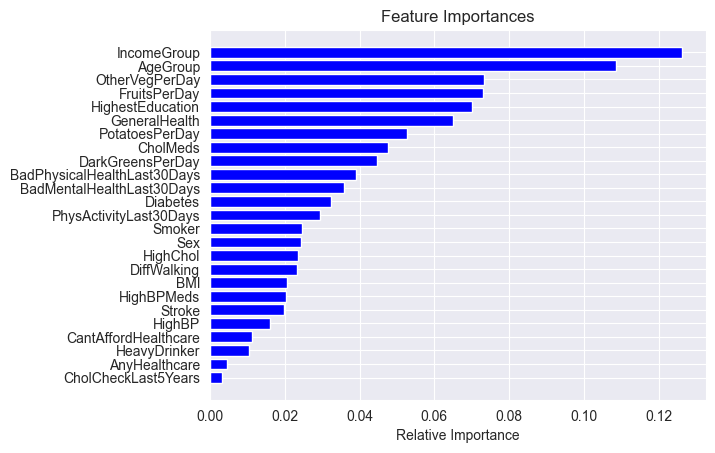

In [145]:
for name, importance in zip(X_cat.columns, rfc.feature_importances_):
    print(name, "=", importance)


features = X_cat.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()